<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
(x, y), (_, _) = tf.keras.datasets.mnist.load_data()

In [11]:
x = np.expand_dims(x, axis=-1)
x = (x - 127.5) / 127.5
x.shape, x.min(), x.max()

((60000, 28, 28, 1), -1.0, 1.0)

In [12]:
buffer_size=x.shape[0]
batch_size=256

In [13]:
x = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)

In [14]:
x

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

In [20]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  network.add(tf.keras.layers.BatchNormalization())
  network.add(tf.keras.layers.LeakyReLU())


  network.add(tf.keras.layers.Reshape((7, 7, 256)))

  network.add(tf.keras.layers.Conv2DTranspose(128, 5, padding='same', use_bias=False))
  network.add(tf.keras.layers.BatchNormalization())
  network.add(tf.keras.layers.LeakyReLU())


  network.add(tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False))
  network.add(tf.keras.layers.BatchNormalization())
  network.add(tf.keras.layers.LeakyReLU())


  network.add(tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh'))

  network.summary()
  return network

In [21]:
generator = build_generator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_1 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)       

In [22]:
noise = tf.random.normal((1, 100))

In [23]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.1135519 , -1.8026693 , -0.14461099, -1.1236316 ,  0.37338278,
        -0.9130582 ,  0.44810486,  1.8999417 , -0.19320573, -0.68791217,
        -0.7820962 , -2.3990161 , -0.4321758 , -0.14107254, -0.02363138,
        -1.7201878 , -0.44618022, -0.6414451 ,  0.07569852, -1.0495553 ,
        -0.87089354, -0.26070902,  0.45454738, -1.0191498 , -3.2249906 ,
         1.241475  , -0.767997  ,  0.1660599 ,  0.8393945 ,  0.31004748,
        -0.07403222,  0.28840336,  0.98822236, -1.6156868 ,  1.4529847 ,
         0.85981333, -0.475735  , -0.5871571 ,  0.23134612,  0.7826554 ,
        -0.8326037 , -0.94829404,  0.76414007, -1.2163076 ,  0.3776317 ,
        -0.76867133,  0.47202745, -0.86645186, -0.02533073, -0.29835132,
         0.2155981 , -0.81308603, -1.2564131 ,  0.24190849, -0.7660533 ,
         1.2441278 ,  0.11248816, -0.40669313, -0.7926386 , -0.5502796 ,
        -0.34174946,  1.1293796 , -0.06790449, -1.050346  , -0.70403606,
 

In [27]:
generated_img = generator(noise, training=False)
generated_img.shape

TensorShape([1, 28, 28, 1])

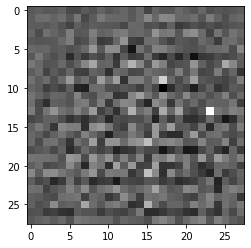

In [35]:
plt.imshow(generated_img[0, :, :, 0], cmap='gray')